In [ ]:
# %%

import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
# %%

#loading MNIST
train_data = dsets.MNIST(root = '/Users/aaronhillman/Desktop/data', train = True,transform = transforms.ToTensor(),
                   download = True)
test_data = dsets.MNIST(root = '/Users/aaronhillman/Deskstop/data', train = False,transform = transforms.ToTensor(),
                   download = True)

##### We load the results from the models which we calculated in the MNIST_training.py script below.

In [ ]:
#%%

with open("loss_data/MLPsizes_cuda.txt", "r") as f:
    MLP_sizes_loaded = np.loadtxt(f)
with open("loss_data/CNN3sizes.txt", "r") as f:
    CNN3_sizes_loaded = np.loadtxt(f)
with open("loss_data/CNN14sizes.txt", "r") as f:
    CNN14_sizes_loaded = np.loadtxt(f)
with open("loss_data/MLPlosses_cuda.txt", "r") as f:
    MLP_losses_loaded = np.loadtxt(f)
with open("loss_data/CNN3losses.txt", "r") as f:
    CNN3_losses_loaded = np.loadtxt(f)
with open("loss_data/CNN14losses.txt", "r") as f:
    CNN14_losses_loaded = np.loadtxt(f)

##### We will do a linear regression on the log-log data in order to estimate the parameters for a power-law fit for the loss.

In [ ]:
#%%

def power_fit(xdata, ydata):
    xlog = [np.log(x) for x in xdata]
    ylog = [np.log(y) for y in ydata]
    A = np.vstack([xlog, np.ones(len(xlog))]).T
    m, c = np.linalg.lstsq(A, ylog)[0]
    print("m: ", m)
    print("c: ", c)

    return m, c

##### We fit to what looks like the longest linear stretch in the spectrum of eigenvalues in the MNIST covariance matrix.  

<ipython-input-4-bd4e4144fadb>:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, ylog)[0]


m:  -1.7907136022827186
c:  5.283460556635136


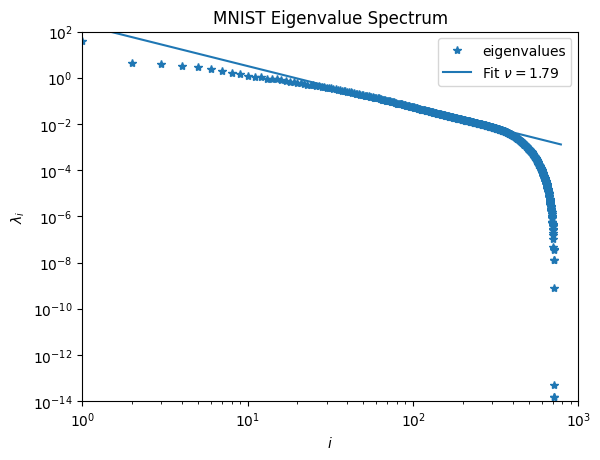

In [ ]:
#%%

#Now MNIST Spectrum plot
Xtr = torch.stack([x[0].view((28*28,)) for x in train_data])
Ytr = torch.tensor([x[1] for x in train_data])
C = Xtr.transpose(-2, -1) @ Xtr / Xtr.shape[0]
eigvals = sorted(np.linalg.eigvalsh(C))[::-1]
ivals = range(1, len(eigvals)+1)
m, c = power_fit([i for i in ivals[40:-450]], eigvals[40:-450])
yfit = [np.exp(c)*x**m for x in ivals]

plt.loglog(ivals, eigvals, "*")
plt.loglog(ivals, yfit, color="tab:blue")
plt.xlim(1e0, 1e3)
plt.ylim(1e-14, 1e2)
plt.xlabel("$i$")
plt.ylabel("$\lambda_i$")
plt.title("MNIST Eigenvalue Spectrum")
plt.legend(["eigenvalues", "Fit $\\nu = 1.79$"])
plt.show()

Here we state the the exponent in the power law $\nu = 1.79$ fitting to the middle sectin of points which is approximately linear.

m:  -1.4118131655319979
c:  4.02029667811379


<ipython-input-4-bd4e4144fadb>:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, ylog)[0]


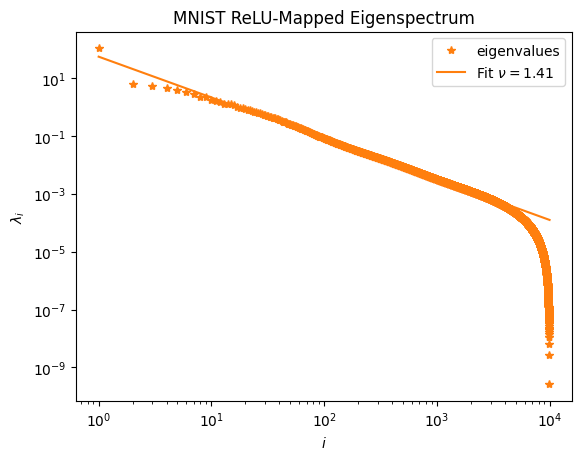

In [ ]:
#%%

def relumapMNIST(Xin, Nout):
    u = nn.Linear(28*28, Nout, bias=False)
    return nn.ReLU()(u(Xin))

P = 10000
XReLU = relumapMNIST(Xtr[0:P], 10000)
C = XReLU.transpose(-2, -1) @ XReLU / P
eigvals = sorted(np.linalg.eigvalsh(C.detach()))[::-1]
ivals = range(1, len(eigvals)+1)
m, c = power_fit([i for i in ivals[50:-8000]], eigvals[50:-8000])
yfit = [np.exp(c)*x**m for x in ivals]

plt.loglog(ivals, eigvals, "*", color="tab:orange")
plt.loglog(ivals, yfit, color="tab:orange")
plt.xlabel("$i$")
plt.ylabel("$\lambda_i$")
plt.title("MNIST ReLU-Mapped Eigenspectrum")
plt.legend(["eigenvalues", "Fit $\\nu = 1.41$"])
plt.show()
plt.show()

##### We see that the ReLU Mapping makes the exponent smaller

In [ ]:
#%%

def relu_ntk(X):
    """
    Compute the NTK for a single hidden layer with ReLU activation in the infinite width limit.
    X1: torch.Tensor of shape (n1, d)
    X2: torch.Tensor of shape (n2, d)
    Returns: torch.Tensor of shape (n1, n2)
    """
    X= X/ torch.norm(X, dim=1, keepdim=True)
   
    
    dot_product = X @ X.T
    # Clip the dot product to the range [-1, 1] to avoid NaNs in arccos
    dot_product = torch.clamp(dot_product, -1.0, 1.0)
    theta = torch.acos(dot_product)
    
    ntk = (torch.sin(theta) + (np.pi - theta) * torch.cos(theta)) / np.pi
    return ntk

<ipython-input-4-bd4e4144fadb>:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, ylog)[0]


m:  -1.3665549899682832
c:  -1.5224706776602912


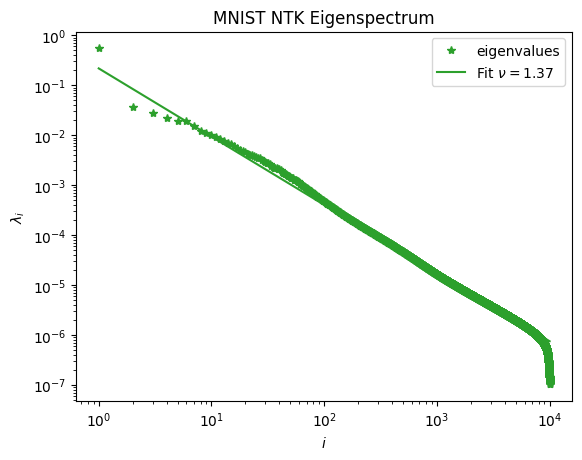

In [ ]:
#%%

P = 10000

ntk_an = relu_ntk(Xtr[0:P])/P
eigvals = sorted(np.linalg.eigvalsh(np.array(ntk_an.detach())))[::-1]
ivals = range(1, len(eigvals)+1)

m, c = power_fit([i for i in ivals[100:-P//4]], eigvals[100:-P//4])
yfit = [np.exp(c)*x**m for x in ivals]

plt.loglog(ivals, eigvals, "*", color="tab:green")
plt.loglog(ivals, yfit, color="tab:green")
plt.xlabel("$i$")
plt.ylabel("$\lambda_i$")
plt.title("MNIST NTK Eigenspectrum")
plt.legend(["eigenvalues", "Fit $\\nu = 1.37$"])
plt.show()

##### For the NTK the power law seems to extend more though the exponent is similar.

<ipython-input-4-bd4e4144fadb>:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, ylog)[0]


m:  -0.6621755836192924
c:  4.383329120146279
m:  -0.5554907210635802
c:  3.98802930710763
m:  -0.5305638345135504
c:  4.263401730264069


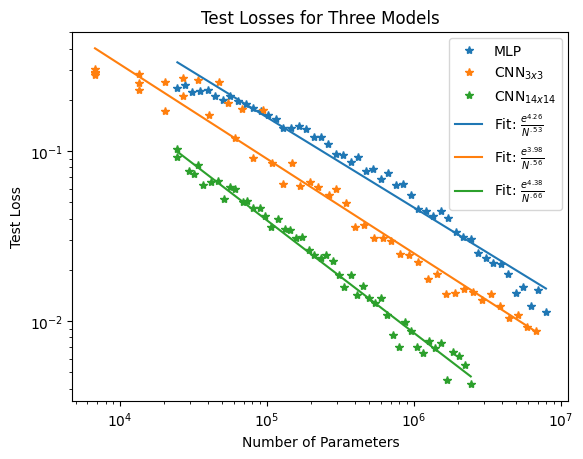

In [ ]:
#%%

#Now test loss fits

CNN14m, CNN14fc = power_fit(CNN14_sizes_loaded, CNN14_losses_loaded)
CNN14fity = [np.exp(CNN14fc)*x**CNN14m for x in CNN14_sizes_loaded]
CNN3m, CNN3c= power_fit(CNN3_sizes_loaded, CNN3_losses_loaded)
CNN3fity = [np.exp(CNN3c)*x**CNN3m for x in CNN3_sizes_loaded]
MLPm, MLPc = power_fit(MLP_sizes_loaded, MLP_losses_loaded)
MLPfity = [np.exp(MLPc)*x**MLPm for x in MLP_sizes_loaded]
plt.loglog(MLP_sizes_loaded, MLP_losses_loaded, "*")
plt.loglog(CNN3_sizes_loaded, CNN3_losses_loaded, "*")
plt.loglog(CNN14_sizes_loaded, CNN14_losses_loaded, "*")
plt.loglog(MLP_sizes_loaded, MLPfity, color = 'tab:blue')
plt.loglog(CNN3_sizes_loaded, CNN3fity, color = 'tab:orange')
plt.loglog(CNN14_sizes_loaded, CNN14fity, color = 'tab:green')
plt.xlabel("Number of Parameters")
plt.ylabel("Test Loss")
plt.legend(["MLP", "$\\text{CNN}_{3x3}$", "$\\text{CNN}_{14x14}$", "Fit: $\\frac{e^{4.26}}{N^{.53}} $", "Fit: $\\frac{e^{3.98}}{N^{.56}} $", "Fit: $\\frac{e^{4.38}}{N^{.66}} $"])
plt.title("Test Losses for Three Models")
plt.savefig("model_scalings")